Labeled sequence of bitter peptides.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import scikitplot as skplt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [65]:
torch.__version__

'1.11.0+cpu'

In [66]:
import torch_geometric

In [67]:
torch_geometric.__version__

'2.0.4'

In [3]:
train_pos = pd.read_csv('train-positive.txt', header=None)
train_neg = pd.read_csv('train-negative.txt', header=None)
test_pos = pd.read_csv('test-positive.txt', header=None)
test_neg = pd.read_csv('test-negative.txt', header=None)

In [4]:
ext_set = pd.read_csv('ext-set.txt', sep = ' ', header=None)

In [5]:
train_pos = pd.DataFrame([train_pos[::2].reset_index(drop=True)[0], train_pos[1::2].reset_index(drop=True)[0]]).T
train_neg = pd.DataFrame([train_neg[::2].reset_index(drop=True)[0], train_neg[1::2].reset_index(drop=True)[0]]).T
test_pos = pd.DataFrame([test_pos[::2].reset_index(drop=True)[0], test_pos[1::2].reset_index(drop=True)[0]]).T
test_neg = pd.DataFrame([test_neg[::2].reset_index(drop=True)[0], test_neg[1::2].reset_index(drop=True)[0]]).T

In [6]:
df = train_pos.append(train_neg).append(test_pos).append(test_neg).reset_index(drop=True)
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: x.split(' ')[0][1:])
df.columns = ['bitter', 'seq']
df

,bitter,seq
0,Positive,GFF
1,Positive,VYPFPPGIGG
2,Positive,EVLN
3,Positive,KAVPYPPQ
4,Positive,FV
...,...,...
635,Negative,MIFPGGPQL
636,Negative,HHL
637,Negative,HIR
638,Negative,NILP


In [7]:
#df = df.sample(frac=1, random_state=7)
labels = df.bitter.apply(lambda x: 1 if x=='Positive' else 0).values
seq = df.seq.values

In [8]:
descriptors = list(set([j for i in seq for j in i]))
enc = OneHotEncoder()
X = np.array(descriptors).reshape((-1, 1))
enc_arrays = enc.fit(X)

In [9]:
def create_graph_data(str, label):
    n = len(str)
    edge_index_up = [[i, i+1] for i in range(n-1)]
    edge_index_down = [[i+1, i] for i in range(n-1)]
    edge_index = torch.tensor(edge_index_down + edge_index_up, dtype=torch.long)

    node_feats = enc.transform([[i] for i in str]).toarray()
    node_features = torch.tensor(node_feats, dtype=torch.float) 
    label = torch.tensor(label)
    d = Data(x = node_features, edge_index=edge_index.t().contiguous(), y = label)

    return(d)

In [10]:
data_list = []

In [11]:
for i in range(len(labels)):
    d = create_graph_data(seq[i], labels[i])
    data_list.append(d)

In [12]:
ext_seq = ext_set.loc[:,0].tolist()
ext_labels = ext_set.loc[:,1].tolist()

In [13]:
ext_data_list = []
for i in range(len(ext_labels)):
    if ext_labels[i] not in labels:
        d = create_graph_data(ext_seq[i], ext_labels[i])
        ext_data_list.append(d)

In [14]:
train_data, test_data = train_test_split(data_list, test_size=0.1, random_state=6)#1

In [15]:
ext_data_list

[]

In [16]:
train_data[0], test_data[0]

(Data(x=[7, 20], edge_index=[2, 12], y=1),
 Data(x=[4, 20], edge_index=[2, 6], y=1))

In [17]:
train_loader = DataLoader(train_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=64)

In [18]:
ext_data_loader = DataLoader(ext_data_list, batch_size=64)

In [19]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 32
DataBatch(x=[127, 20], edge_index=[2, 190], y=[32], batch=[127], ptr=[33])

Step 2:
Number of graphs in the current batch: 32
DataBatch(x=[142, 20], edge_index=[2, 220], y=[32], batch=[142], ptr=[33])

Step 3:
Number of graphs in the current batch: 32
DataBatch(x=[169, 20], edge_index=[2, 274], y=[32], batch=[169], ptr=[33])

Step 4:
Number of graphs in the current batch: 32
DataBatch(x=[210, 20], edge_index=[2, 356], y=[32], batch=[210], ptr=[33])

Step 5:
Number of graphs in the current batch: 32
DataBatch(x=[176, 20], edge_index=[2, 288], y=[32], batch=[176], ptr=[33])

Step 6:
Number of graphs in the current batch: 32
DataBatch(x=[183, 20], edge_index=[2, 302], y=[32], batch=[183], ptr=[33])

Step 7:
Number of graphs in the current batch: 32
DataBatch(x=[179, 20], edge_index=[2, 294], y=[32], batch=[179], ptr=[33])

Step 8:
Number of graphs in the current batch: 32
DataBatch(x=[174, 20], edge_index=[2, 284], y=[32], batch=[174], ptr

In [20]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(20, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(20, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (conv5): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [21]:
hidden_channels = 16
epochs = 30

In [22]:
model = GCN(hidden_channels=hidden_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(epochs):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Train Acc: 0.5590, Test Acc: 0.5625
Epoch: 001, Train Acc: 0.7257, Test Acc: 0.7031
Epoch: 002, Train Acc: 0.7205, Test Acc: 0.6562
Epoch: 003, Train Acc: 0.8038, Test Acc: 0.7500
Epoch: 004, Train Acc: 0.8142, Test Acc: 0.7500
Epoch: 005, Train Acc: 0.8299, Test Acc: 0.7656
Epoch: 006, Train Acc: 0.7726, Test Acc: 0.6562
Epoch: 007, Train Acc: 0.8403, Test Acc: 0.7969
Epoch: 008, Train Acc: 0.8524, Test Acc: 0.7656
Epoch: 009, Train Acc: 0.8542, Test Acc: 0.7812
Epoch: 010, Train Acc: 0.8802, Test Acc: 0.8125
Epoch: 011, Train Acc: 0.8819, Test Acc: 0.7969
Epoch: 012, Train Acc: 0.8837, Test Acc: 0.8594
Epoch: 013, Train Acc: 0.8733, Test Acc: 0.8125
Epoch: 014, Train Acc: 0.8628, Test Acc: 0.7656
Epoch: 015, Train Acc: 0.8438, Test Acc: 0.7656
Epoch: 016, Train Acc: 0.9010, Test Acc: 0.8281
Epoch: 017, Train Acc: 0.8802, Test Acc: 0.7500
Epoch: 018, Train Acc: 0.8715, Test Acc: 0.7344
Epoch: 019, Train Acc: 0.8715, Test Acc: 0.7969
Epoch: 020, Train Acc: 0.8837, Test Acc:

In [23]:
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    lab = data.y

In [24]:
out.shape

torch.Size([64, 2])

In [25]:
lab.shape

torch.Size([64])

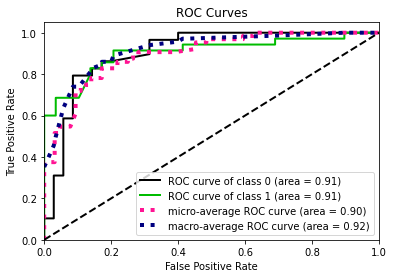

In [26]:
skplt.metrics.plot_roc(lab, out.detach().numpy())
plt.show()

In [27]:
for data in ext_data_loader:
    ext_out = model(data.x, data.edge_index, data.batch)
    ext_lab = data.y
    print(data.y, ext_out)

In [28]:
model

GCN(
  (conv1): GCNConv(20, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (conv4): GCNConv(16, 16)
  (conv5): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)

In [29]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [30]:
train_graph_embeddings = []
for data in train_loader:
    out = model(data.x, data.edge_index, data.batch)
    lab = data.y

    model.conv3.register_forward_hook(get_activation('conv3'))
    output = model(data.x, data.edge_index, data.batch)
    conv3_feats = activation['conv3']

    for i in torch.unique(data.batch):
        node_indexes = (data.batch == i).nonzero().ravel()

        original_enc = data.x[node_indexes]


        desc = ''.join(list(enc.inverse_transform(original_enc).ravel()))

        d = {'desc':desc, 'n_nodes':len(node_indexes), 'label':lab[i].tolist(), 'pred_val':out[i], 'conv3_feats':conv3_feats[node_indexes]}
        train_graph_embeddings.append(d)
len(train_graph_embeddings)    

576

In [31]:
test_graph_embeddings = []
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    lab = data.y

    model.conv3.register_forward_hook(get_activation('conv3'))
    output = model(data.x, data.edge_index, data.batch)
    conv3_feats = activation['conv3']

    for i in torch.unique(data.batch):
        node_indexes = (data.batch == i).nonzero().ravel()

        original_enc = data.x[node_indexes]


        desc = ''.join(list(enc.inverse_transform(original_enc).ravel()))

        d = {'desc':desc, 'n_nodes':len(node_indexes), 'label':lab[i].tolist(), 'pred_val':out[i], 'conv3_feats':conv3_feats[node_indexes]}
        test_graph_embeddings.append(d)
len(test_graph_embeddings)    

64

In [32]:
all_graph_embeddings = test_graph_embeddings + train_graph_embeddings

## Graph level embedding

### All embeddings

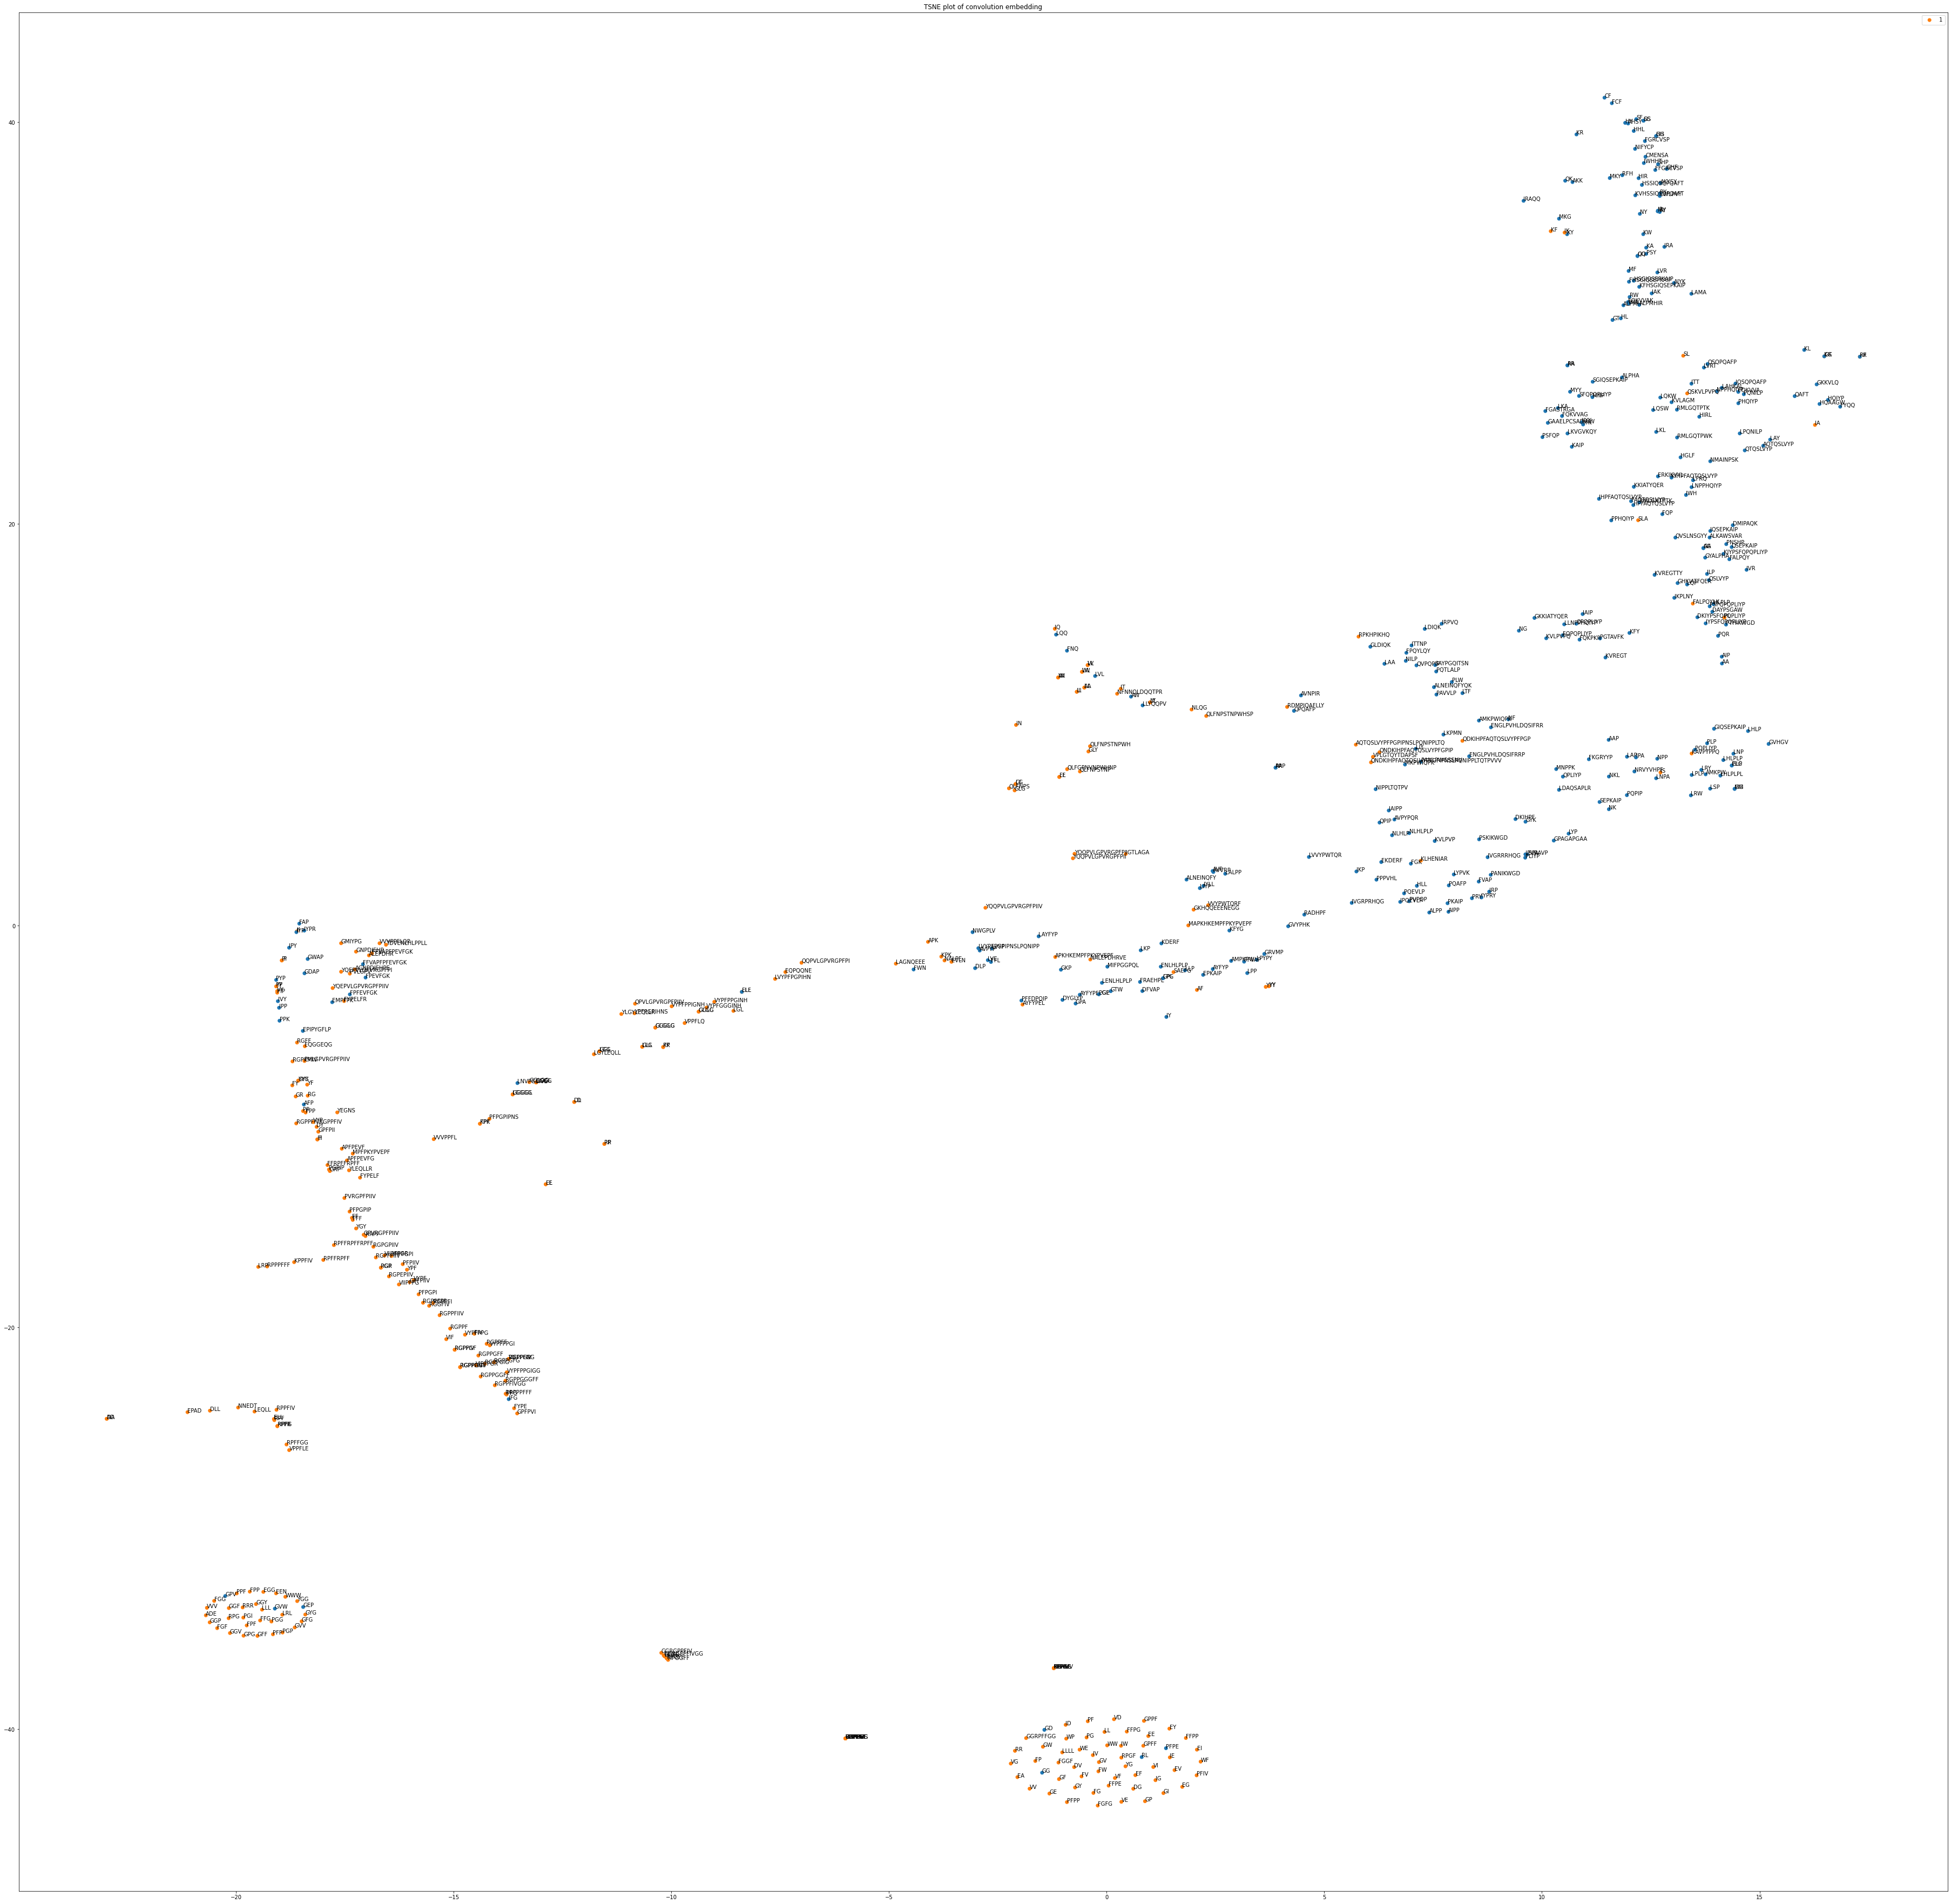

In [33]:
descs = []
conv_feats = np.zeros((len(all_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(all_graph_embeddings)):
    descs.append(all_graph_embeddings[i]['desc'])
    conv_feats[i] = all_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(all_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])
tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

plt.figure(figsize=(64, 64))
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend(labels)
for i, l in enumerate(descs):
    #if i%15 == 0:
        plt.annotate(l, (tsne_embd[i, 0], tsne_embd[i, 1]), size = 10)
plt.title('TSNE plot of convolution embedding')
plt.savefig('TSNE Embedding plot.pdf')
plt.show()


In [34]:
tsne_embd

array([[  2.067424  , -42.299194  ],
       [-18.44148   ,  -8.902238  ],
       [  9.6201515 ,   3.5516179 ],
       ...,
       [ 12.812016  ,  33.794216  ],
       [ 17.303162  ,  28.323595  ],
       [  0.33815613, -41.41859   ]], dtype=float32)

### Train

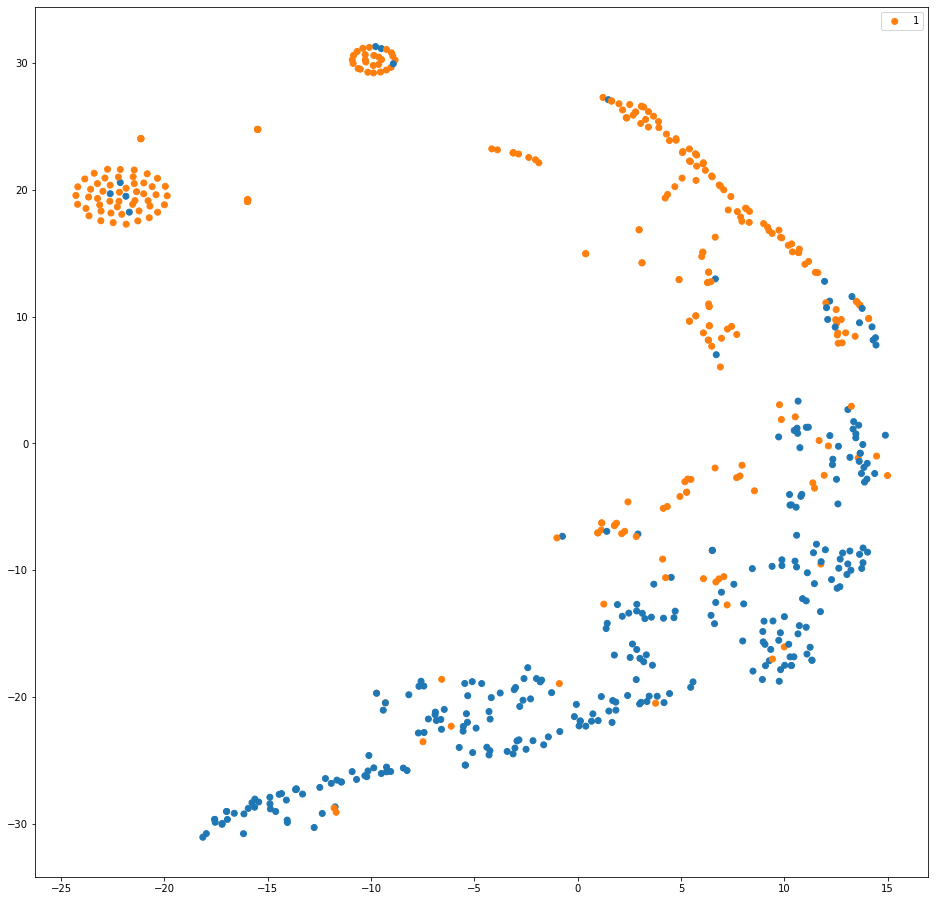

In [35]:
descs = []
conv_feats = np.zeros((len(train_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(train_graph_embeddings)):
    descs.append(train_graph_embeddings[i]['desc'])
    conv_feats[i] = train_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(train_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])

tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

plt.figure(figsize=(16, 16))
plt.legend(labels)
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend(labels)
plt.show()
#for i, l in enumerate(descs):
#    plt.annotate(l, (pca_embd[i, 0], pca_embd[i, 1]))

#### Test

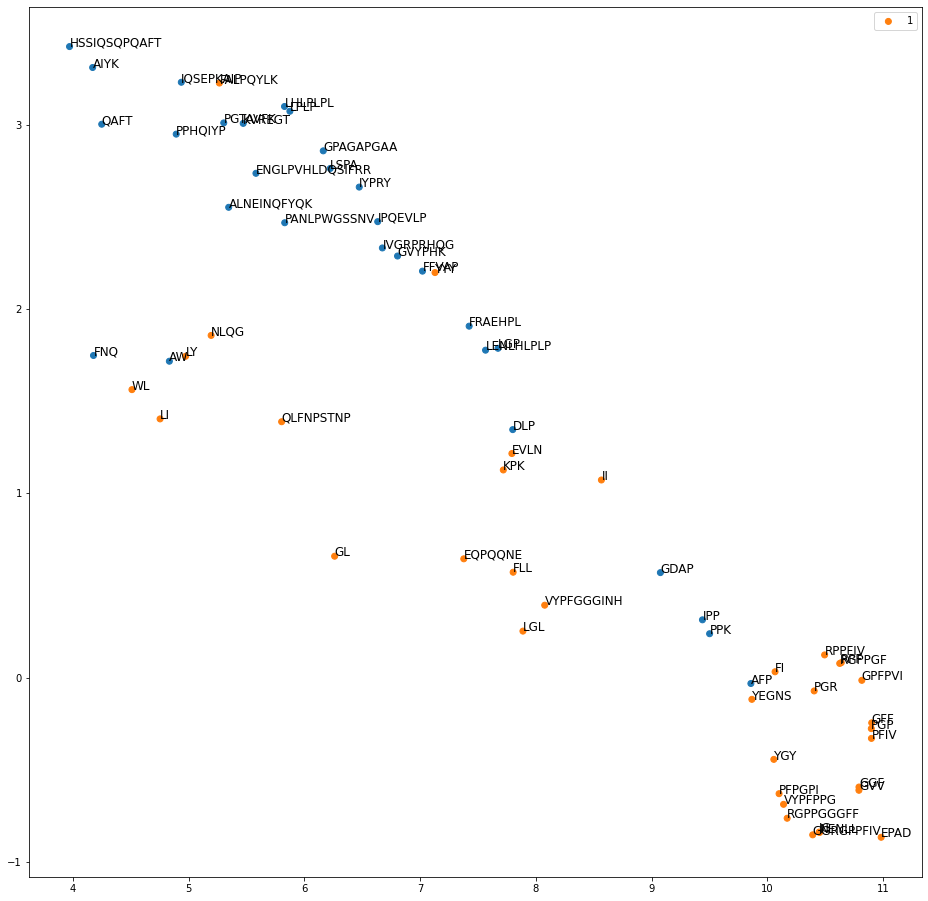

In [36]:
descs = []
conv_feats = np.zeros((len(test_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(test_graph_embeddings)):
    descs.append(test_graph_embeddings[i]['desc'])
    conv_feats[i] = test_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(test_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])

tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

plt.figure(figsize=(16, 16))
plt.legend(labels)
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend(labels)
for i, l in enumerate(descs):
    plt.annotate(l, (tsne_embd[i, 0], tsne_embd[i, 1]), size=12)
plt.show()

## Node level embeddings: All Data 

In [37]:
descs = []
conv_feats = []
labels = []
pred_vals = []
for i in range(len(all_graph_embeddings)):
    descs.append(all_graph_embeddings[i]['desc'])
    conv_feats.append(all_graph_embeddings[i]['conv3_feats'].mean(axis = 1).detach().tolist())
    labels.append(all_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])


In [38]:
pos_samples = []
neg_samples = []
for i in range(len(conv_feats)):
    if labels[i] == 1:
        pos_samples.append(np.mean(conv_feats[i]))
    else:
        neg_samples.append(np.mean(conv_feats[i]))

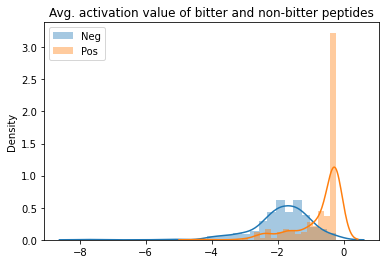

In [39]:
sns.distplot(neg_samples, label='Neg')
sns.distplot(pos_samples, label='Pos')
plt.legend()
plt.title('Avg. activation value of bitter and non-bitter peptides')
plt.show()

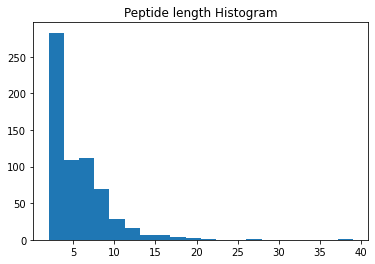

In [40]:
plt.hist([len(i) for i in descs], bins = 20)
plt.title('Peptide length Histogram')
plt.show()

In [41]:
pos_descs = {}
neg_descs = {}
for i in range(len(labels)):
    k = descs[i]
    v = conv_feats[i]
    if labels[i] == 1:
        for _, d in enumerate(k):
            if d in pos_descs.keys():
                pos_descs[d].append(v[_])
            else:
                pos_descs[d] = [v[_]]
    else:
        for _, d in enumerate(k):
            if d in neg_descs.keys():
                neg_descs[d].append(v[_])
            else:
                neg_descs[d] = [v[_]]

In [42]:
desc_keys = sorted(list(set(list(pos_descs.keys()) + list(neg_descs.keys()))))

In [43]:
pos_desc_avg = []
neg_desc_avg = []
desc_avg = []
pos_desc_count = np.arange(len(desc_keys))
neg_desc_count = np.arange(len(desc_keys))

for i, k in enumerate(desc_keys):
    if k in pos_descs.keys():
        pos_desc_avg.append(np.mean(pos_descs[k]))
        pos_desc_count[i] = pos_desc_count[i] + len(pos_descs[k])
    else:
        pos_desc_avg.append(0)

    if k in neg_descs.keys():
        neg_desc_avg.append(np.mean(neg_descs[k]))
        neg_desc_count[i] = neg_desc_count[i] + len(neg_descs[k])
    else:
        neg_desc_avg.append(0)


In [44]:
all_graph_embeddings[0]

{'desc': 'PFIV',
 'n_nodes': 4,
 'label': 1,
 'pred_val': tensor([-1.3590,  1.4671], grad_fn=<SelectBackward0>),
 'conv3_feats': tensor([[-0.4226, -0.6975, -1.1266, -0.4162,  1.1238, -0.3003, -0.2579, -0.8756,
          -0.4003, -0.2574, -0.2044, -0.3003, -0.0925, -0.5623,  0.5621,  0.5045],
         [-0.4226, -0.6975, -1.1266, -0.4162,  1.1238, -0.3003, -0.2579, -0.8756,
          -0.4003, -0.2574, -0.2044, -0.3003, -0.0925, -0.5623,  0.5621,  0.5045],
         [-0.4226, -0.6975, -1.1266, -0.4162,  1.1238, -0.3003, -0.2579, -0.8756,
          -0.4003, -0.2574, -0.2044, -0.3003, -0.0925, -0.5623,  0.5621,  0.5045],
         [-0.4226, -0.6975, -1.1266, -0.4162,  1.1238, -0.3003, -0.2579, -0.8756,
          -0.4003, -0.2574, -0.2044, -0.3003, -0.0925, -0.5623,  0.5621,  0.5045]])}

In [45]:
all_graph_embeddings[0]['conv3_feats'].mean(axis = 1)

tensor([-0.2327, -0.2327, -0.2327, -0.2327])

for i, g in enumerate(all_graph_embeddings):
    print(g['desc'])

In [46]:
[i['desc'] for i in all_graph_embeddings]

['PFIV',
 'AFP',
 'LSPA',
 'PGR',
 'EVLN',
 'YEGNS',
 'RPF',
 'IQSEPKAIP',
 'WL',
 'YGY',
 'FRAEHPL',
 'FNQ',
 'DLP',
 'EPAD',
 'PANLPWGSSNV',
 'FFVAP',
 'GPFPVI',
 'GPAGAPGAA',
 'LPLP',
 'IPQEVLP',
 'FALPQYLK',
 'LI',
 'VYPFPPG',
 'LHLPLPL',
 'FI',
 'PGP',
 'LENLHLPLP',
 'QAFT',
 'IPP',
 'GVV',
 'GL',
 'VYPFGGGINH',
 'AIYK',
 'RPPFIV',
 'RGPPGGGFF',
 'GGRGPPFIV',
 'PGTAVFK',
 'FLL',
 'NENLL',
 'ALNEINQFYQK',
 'II',
 'PFPGPI',
 'GVYPHK',
 'YYY',
 'AW',
 'IVGRPRHQG',
 'KVREGT',
 'HSSIQSQPQAFT',
 'NLQG',
 'EQPQQNE',
 'PPK',
 'IYPRY',
 'KPK',
 'PPHQIYP',
 'RGPPGF',
 'LGL',
 'GGF',
 'GDAP',
 'LGP',
 'GFF',
 'IG',
 'ENGLPVHLDQSIFRR',
 'LY',
 'QLFNPSTNP',
 'EQGGEQG',
 'DG',
 'FGASTRGA',
 'PFPE',
 'AGNPDIEHPE',
 'WF',
 'EY',
 'AIP',
 'IAK',
 'GP',
 'QLFNPS',
 'ADE',
 'GNPDIEHP',
 'VL',
 'YY',
 'RPFF',
 'KVLPVP',
 'SLA',
 'RGPPGGV',
 'YF',
 'FFF',
 'FGFG',
 'LDIQK',
 'GI',
 'FAP',
 'AV',
 'EMPFPK',
 'PP',
 'NG',
 'GPG',
 'AYFYPE',
 'RFH',
 'QPLIYP',
 'ALPP',
 'NF',
 'PI',
 'ITT',
 'PPF',
 'LD'

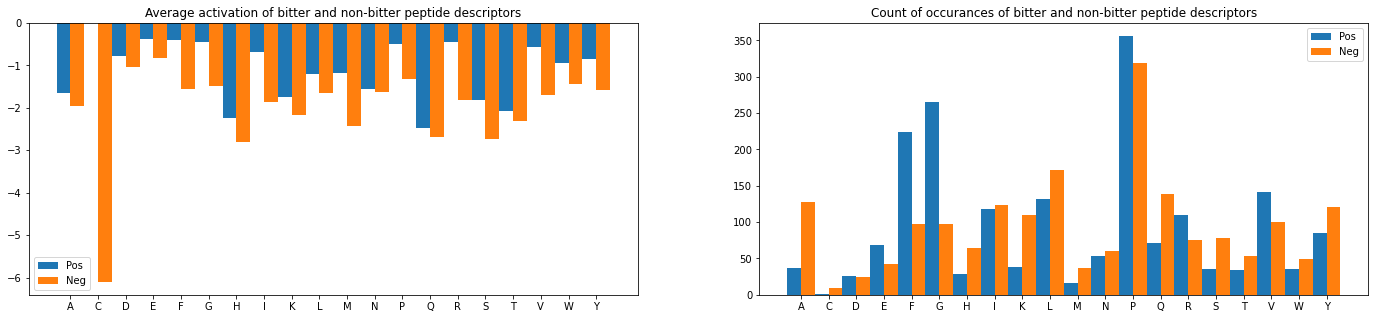

In [47]:
fig, ax = plt.subplots(1,2,figsize=(24,5))
ax[0].bar(x=np.arange(20)-0.25, height = pos_desc_avg, width=-.5)
ax[0].bar(x=np.arange(20)+0.25, height = neg_desc_avg, width=-.5)
ax[0].set_xticks(np.arange(20), desc_keys)
ax[0].legend(['Pos', 'Neg'])
ax[0].set_title('Average activation of bitter and non-bitter peptide descriptors')

ax[1].bar(x=np.arange(20)-0.25, height = pos_desc_count, width=-.5)
ax[1].bar(x=np.arange(20)+0.25, height = neg_desc_count, width=-.5)
ax[1].set_xticks(np.arange(20), desc_keys)
ax[1].legend(['Pos', 'Neg'])
ax[1].set_title('Count of occurances of bitter and non-bitter peptide descriptors')
plt.show()

In [48]:
for k in range(len(all_graph_embeddings)):
    all_graph_embeddings[k]['avg_desc_act'] = all_graph_embeddings[k]['conv3_feats'].mean(axis=1)

In [49]:
import itertools

In [50]:
bidesc_keys = []
bidesc_dict = {}
neg_bidesc_dict = {}
pos_bidesc_dict = {}
bidesc_avg_val = np.zeros(shape=(20,20))
neg_bidesc_avg_val = np.zeros(shape=(20,20))
pos_bidesc_avg_val = np.zeros(shape=(20,20))

for i, k in enumerate(itertools.product(desc_keys, desc_keys)):
    bidesc_keys.append(''.join(k))
bidesc_keys = np.reshape(bidesc_keys, (20,20))

bidesc_population = np.zeros(shape=(20,20))

for k,v in bidesc_dict.items():
    print(k,len(v))

In [51]:
for i, d in enumerate(all_graph_embeddings):
    for j in range(len(d['desc']) - 1):
        if d['desc'][j:j+2] not in bidesc_dict.keys():
            bidesc_dict[d['desc'][j:j+2]] = [float(sum(d['avg_desc_act'][j:j+2]))]
        else:
            bidesc_dict[d['desc'][j:j+2]] = bidesc_dict[d['desc'][j:j+2]] + [float(sum(d['avg_desc_act'][j:j+2]))]


In [52]:
for i in range(len(bidesc_keys)):
    for j in range(len(bidesc_keys[i])):
        if bidesc_keys[i][j] in bidesc_dict.keys():
            bidesc_avg_val[i][j] = np.mean(bidesc_dict[bidesc_keys[i][j]])    
        else:
            bidesc_avg_val[i][j] = np.nan#-49    


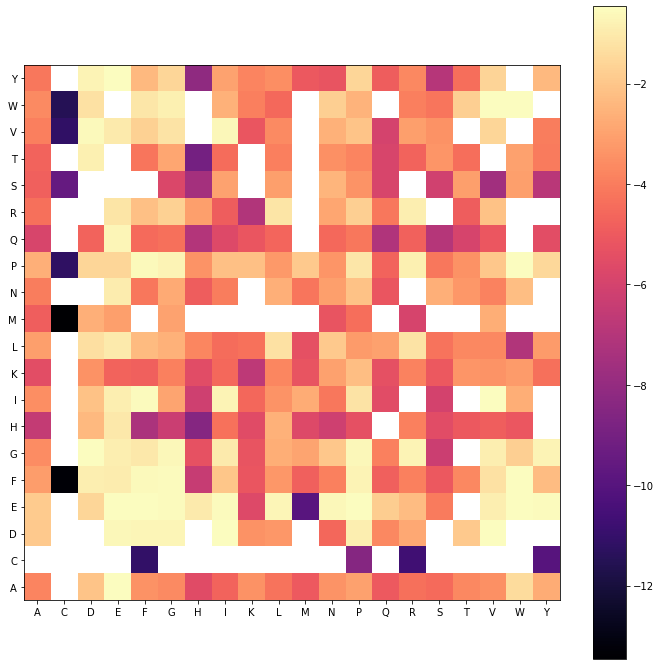

In [53]:
plt.figure(figsize=(12,12))
#plt.imshow(np.rot90(np.array(desc_avg).reshape(20, 1)*np.array(desc_avg).reshape(1, 20)))
plt.imshow(np.rot90(bidesc_avg_val), cmap='magma')
plt.xticks(np.arange(20), desc_keys, minor=False)
plt.yticks(np.arange(20), desc_keys[::-1])
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Average activation of peptide descriptors')

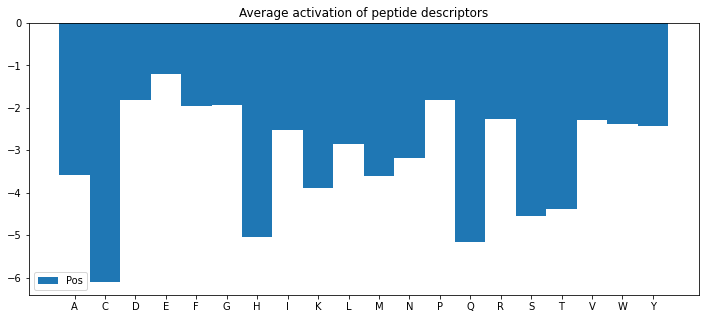

In [56]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.bar(x=np.arange(20), height = np.array(pos_desc_avg) + np.array(neg_desc_avg), width=-1)
ax.set_xticks(np.arange(20), desc_keys)
ax.legend(['Pos', 'Neg'])
ax.set_title('Average activation of peptide descriptors')

In [57]:
desc_avg = np.array(pos_desc_avg) + np.array(neg_desc_avg)

In [75]:
import collections

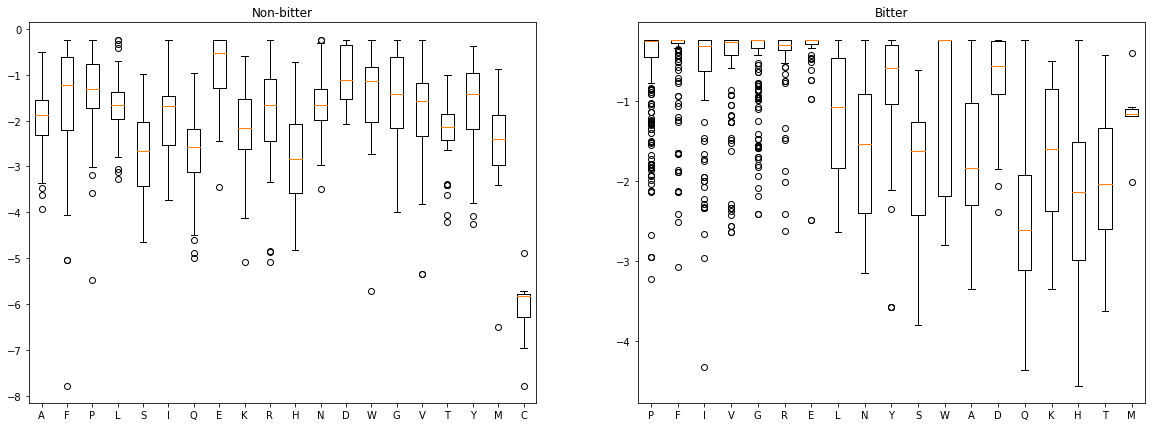

In [68]:
fig, ax = plt.subplots(1,2, figsize = (20,7))
ax[0].boxplot(neg_descs.values())
ax[0].set_xticklabels(neg_descs.keys())
ax[0].set_title('Non-bitter')
ax[1].boxplot(pos_descs.values())
ax[1].set_xticklabels(pos_descs.keys())
ax[1].set_title('Bitter')
plt.show()

Seq: EKDERF, Label: 0, Cls prob: [0.3153716027736664, -0.28124862909317017]


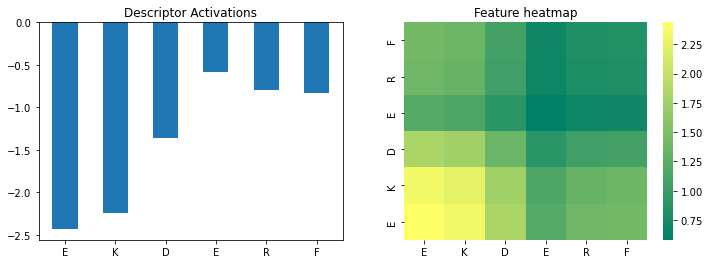

Seq: KFHSGIQSEPKAIP, Label: 0, Cls prob: [1.869553565979004, -1.9041250944137573]


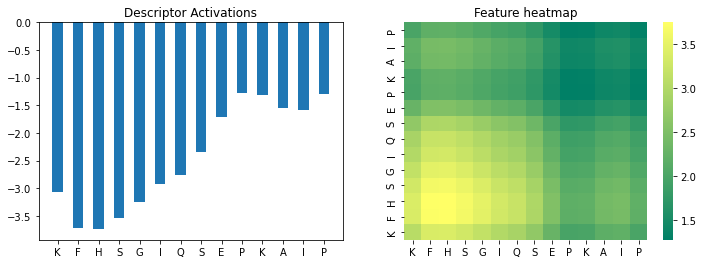

Seq: PFPP, Label: 1, Cls prob: [-1.3590346574783325, 1.4671423435211182]


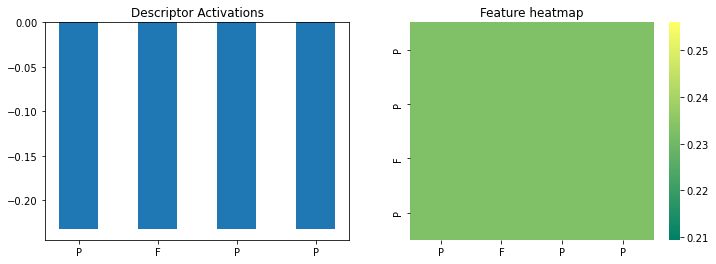

Seq: VF, Label: 1, Cls prob: [-1.3590346574783325, 1.4671423435211182]


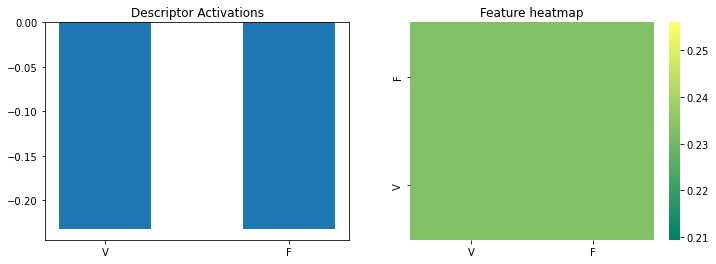

Seq: NWGPLV, Label: 0, Cls prob: [-0.29605215787887573, 0.35718411207199097]


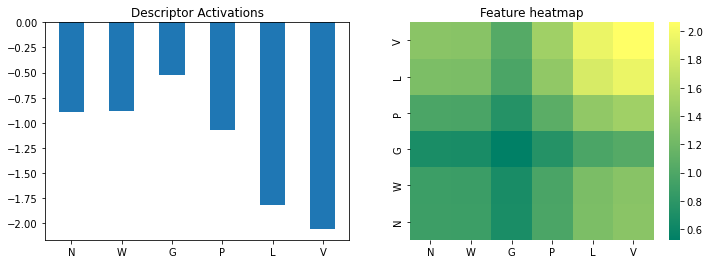

Seq: FGK, Label: 0, Cls prob: [0.5973113179206848, -0.5756592750549316]


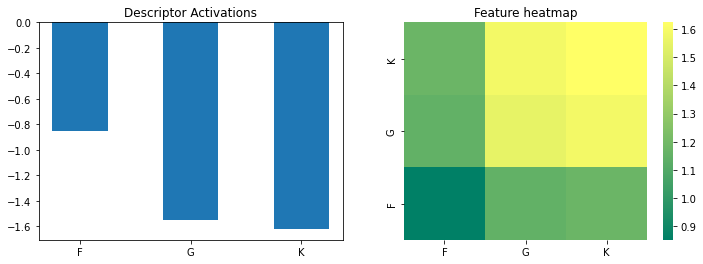

Seq: NRVYVHPF, Label: 0, Cls prob: [1.1195948123931885, -1.1210236549377441]


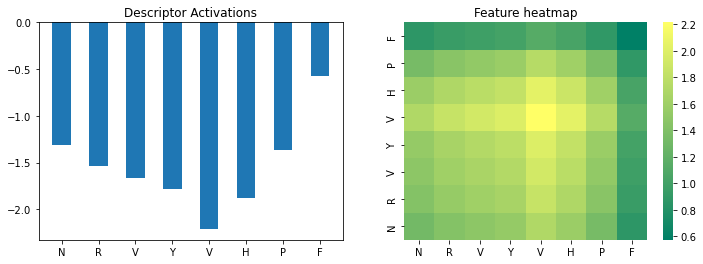

Seq: RGPEPIIV, Label: 1, Cls prob: [-1.3590346574783325, 1.4671423435211182]


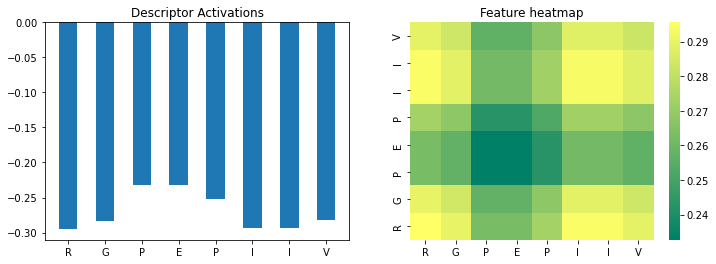

In [59]:
for i in np.random.choice(640, 15):
    if 'P' in descs[i] or 'F' in descs[i]:
        print(f'Seq: {descs[i]}, Label: {labels[i]}, Cls prob: {pred_vals[i].tolist()}')
        fig, ax = plt.subplots(1,2,figsize=(12, 4))
        #print(f'Activation: {conv_feats[i]}')
        ax[0].bar(x=np.arange(len(descs[i])), height = conv_feats[i], width=-.5)
        #plt.plot(conv_feats[i])
        ax[0].set_xticks(np.arange(len(descs[i])), [c for c in descs[i]])
        ax[0].set_title('Descriptor Activations')
        sns.heatmap(np.sqrt(np.rot90(np.abs(np.matmul(np.matrix(conv_feats[i]).T, np.matrix(conv_feats[i]))))), cmap = 'summer', ax = ax[1]) #annot=True, 

        ax[1].set_xticks(np.arange(len(descs[i]))+0.5, labels=[c for c in descs[i]])
        ax[1].set_yticks(np.arange(len(descs[i]))+0.5, labels=descs[i][::-1])
        ax[1].set_title('Feature heatmap')
        plt.show()

Seq: VI, Label: 1, Cls prob: [-1.3590346574783325, 1.4671423435211182]


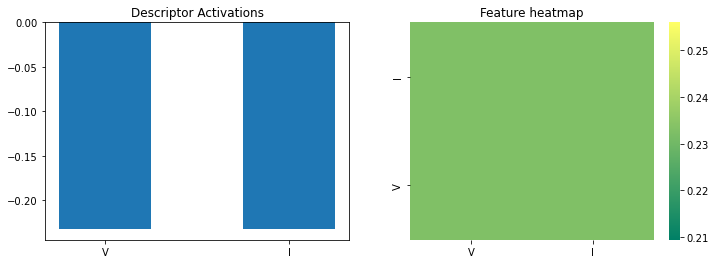

Seq: QPLIYP, Label: 0, Cls prob: [0.8770738244056702, -0.867784857749939]


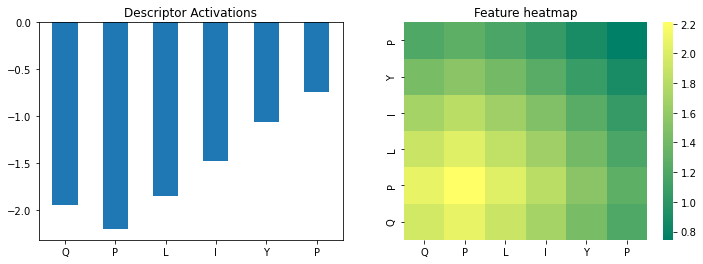

Seq: IAIPP, Label: 0, Cls prob: [0.5452648997306824, -0.5213125944137573]


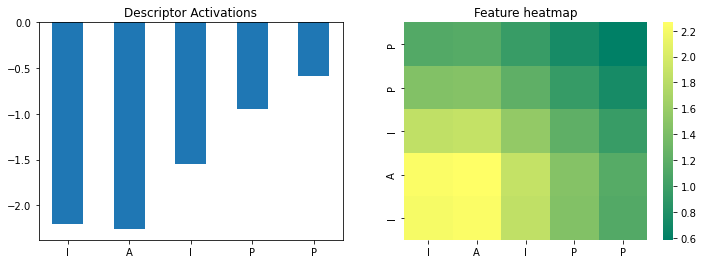

Seq: IN, Label: 1, Cls prob: [-1.3590346574783325, 1.4671423435211182]


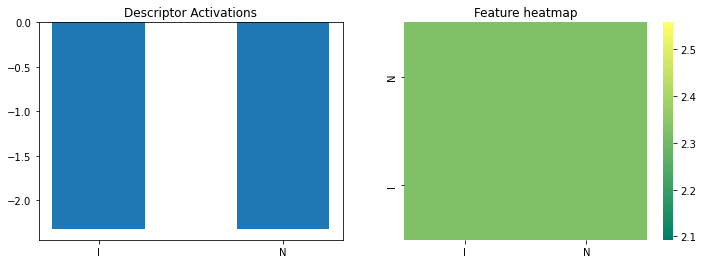

Seq: IYPR, Label: 0, Cls prob: [0.33980628848075867, -0.30677446722984314]


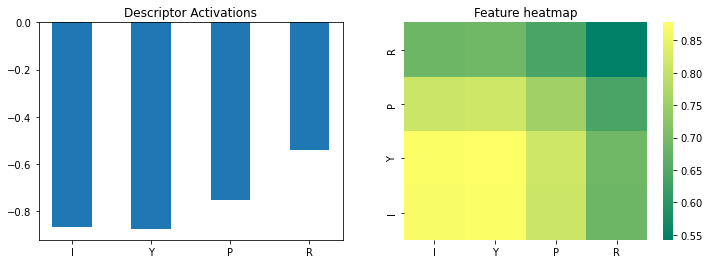

Seq: IPA, Label: 0, Cls prob: [1.2945834398269653, -1.3037455081939697]


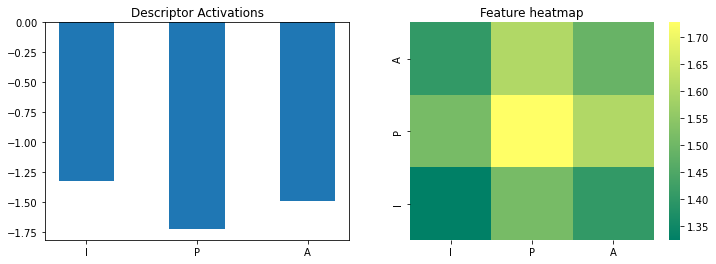

Seq: RGPEPIIV, Label: 1, Cls prob: [-1.3590346574783325, 1.4671423435211182]


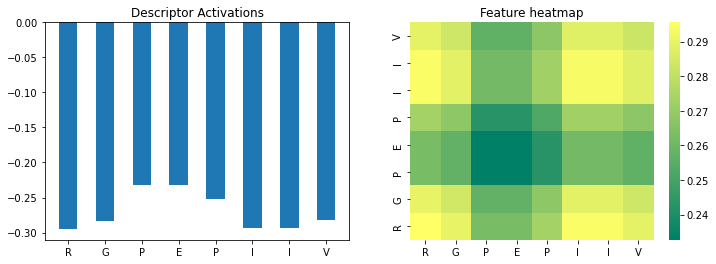

Seq: KIHPFAQTQSLVYP, Label: 0, Cls prob: [0.6939345598220825, -0.6765522956848145]


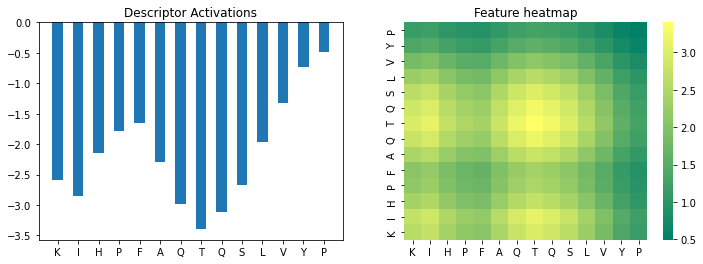

Seq: PQAFP, Label: 0, Cls prob: [0.6798355579376221, -0.6618304252624512]


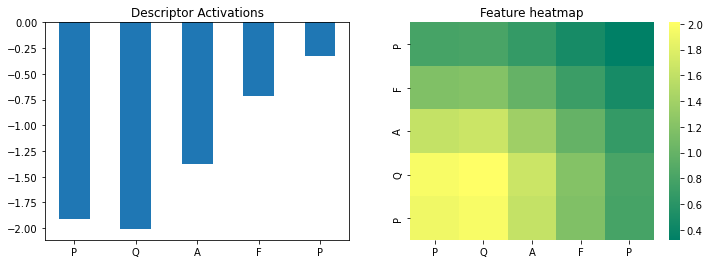

Seq: GY, Label: 1, Cls prob: [-1.3590346574783325, 1.4671423435211182]


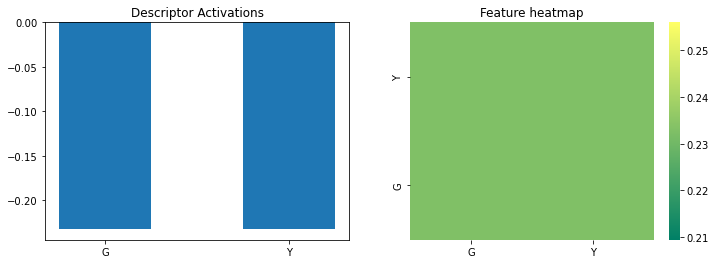

Seq: FQKVVA, Label: 0, Cls prob: [1.022322177886963, -1.0194522142410278]


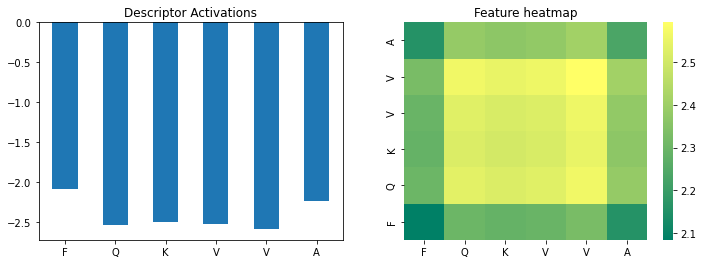

Seq: VF, Label: 1, Cls prob: [-1.3590346574783325, 1.4671423435211182]


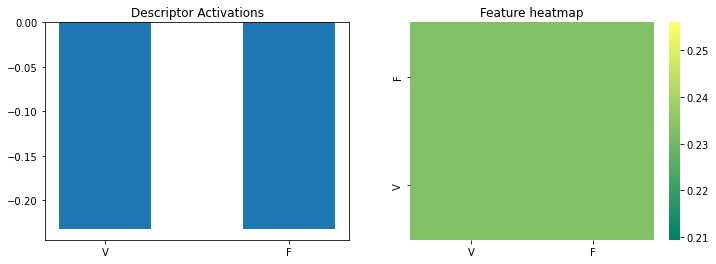

Seq: YY, Label: 1, Cls prob: [0.8786659836769104, -0.8694479465484619]


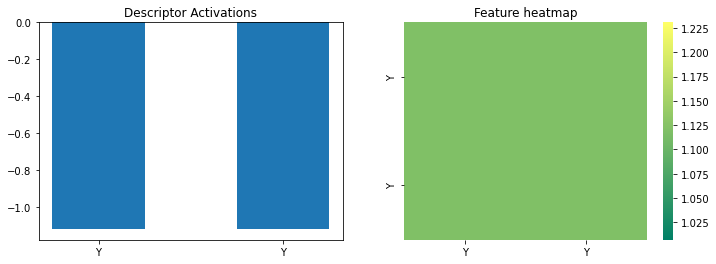

Seq: FGFG, Label: 1, Cls prob: [-1.3590346574783325, 1.4671423435211182]


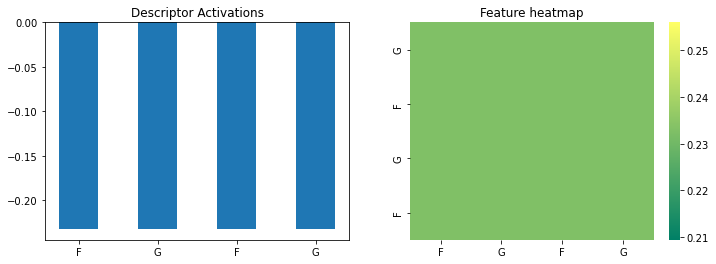

Seq: YLEQLLR, Label: 1, Cls prob: [-1.1146754026412964, 1.2119840383529663]


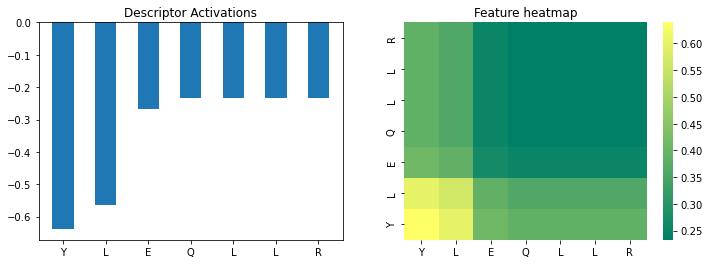

In [60]:
#i = np.random.randint(640)
#print(i)
for i in np.random.choice(640, 15):
    print(f'Seq: {descs[i]}, Label: {labels[i]}, Cls prob: {pred_vals[i].tolist()}')
    fig, ax = plt.subplots(1,2,figsize=(12, 4))
    #print(f'Activation: {conv_feats[i]}')
    ax[0].bar(x=np.arange(len(descs[i])), height = conv_feats[i], width=-.5)
    #plt.plot(conv_feats[i])
    ax[0].set_xticks(np.arange(len(descs[i])), [c for c in descs[i]])
    ax[0].set_title('Descriptor Activations')
    sns.heatmap(np.sqrt(np.rot90(np.abs(np.matmul(np.matrix(conv_feats[i]).T, np.matrix(conv_feats[i]))))), cmap = 'summer', ax = ax[1]) #annot=True, 

    ax[1].set_xticks(np.arange(len(descs[i]))+0.5, labels=[c for c in descs[i]])
    ax[1].set_yticks(np.arange(len(descs[i]))+0.5, labels=descs[i][::-1])
    ax[1].set_title('Feature heatmap')
    plt.show()

Seq: RGPPFF, Label: 1, Cls prob: [-1.3590346574783325, 1.4671423435211182]


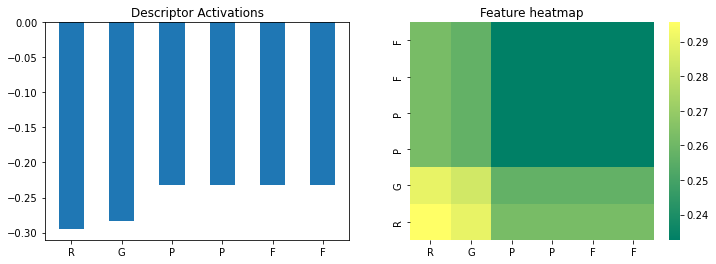

Seq: LALPP, Label: 0, Cls prob: [0.26943787932395935, -0.23329627513885498]


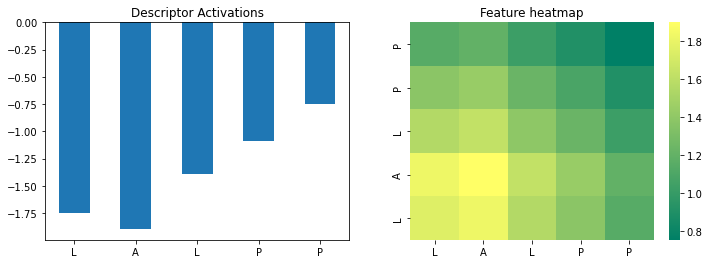

Seq: LAY, Label: 0, Cls prob: [0.23823988437652588, -0.2007194459438324]


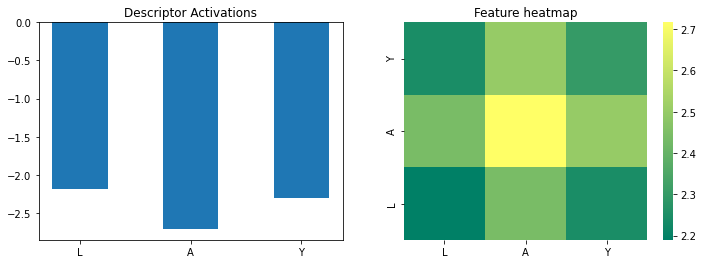

Seq: RMLGQTPTK, Label: 0, Cls prob: [1.0539270639419556, -1.0524539947509766]


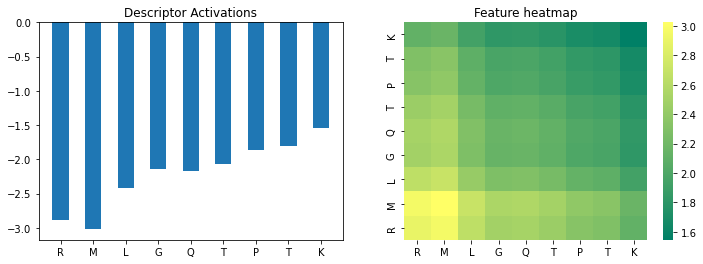

Seq: DMIPAQK, Label: 0, Cls prob: [1.526179313659668, -1.5455763339996338]


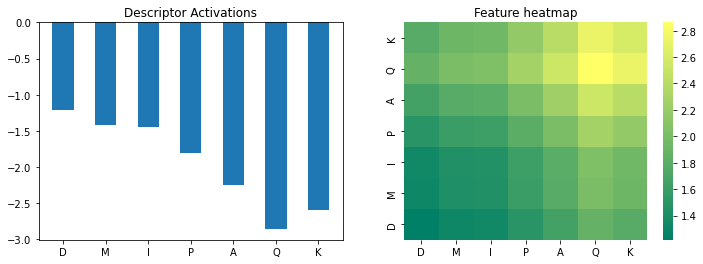

Seq: QPIP, Label: 0, Cls prob: [0.5578674077987671, -0.5344722270965576]


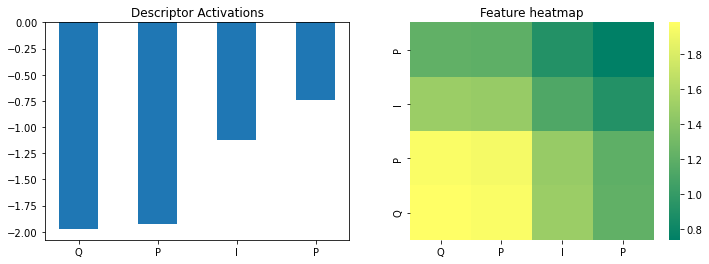

Seq: RPGGFF, Label: 1, Cls prob: [-1.3590346574783325, 1.4671423435211182]


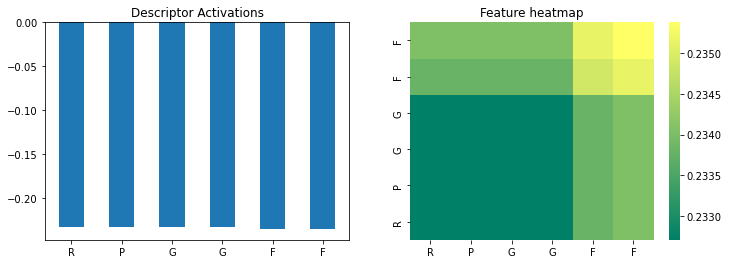

Seq: HGLF, Label: 0, Cls prob: [0.795005738735199, -0.7820901870727539]


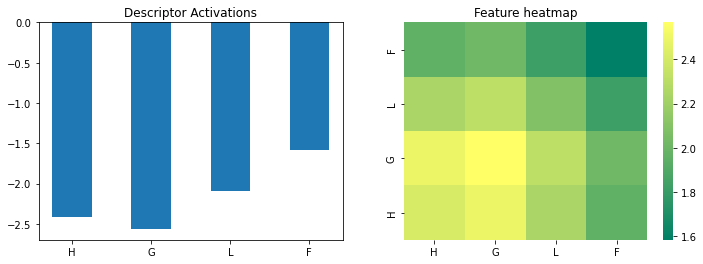

Seq: APFPEVFG, Label: 1, Cls prob: [-1.216132640838623, 1.317924976348877]


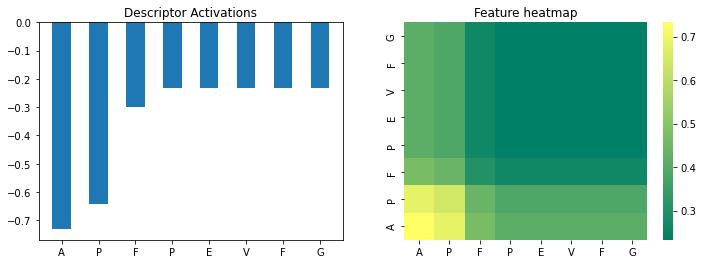

Seq: DFVAP, Label: 0, Cls prob: [0.30369147658348083, -0.26906365156173706]


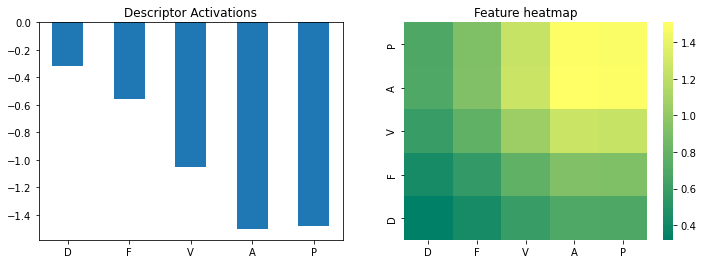

Seq: PVPQP, Label: 0, Cls prob: [0.6406686902046204, -0.6209328174591064]


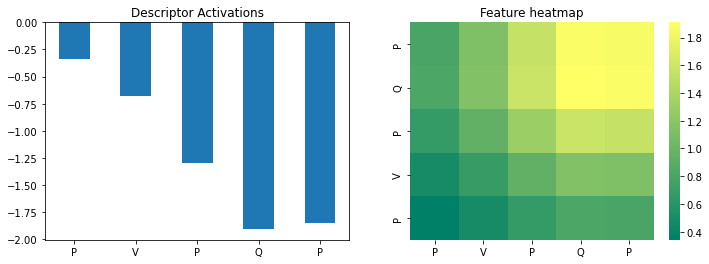

Seq: GNPDIEHP, Label: 1, Cls prob: [-0.22155818343162537, 0.279398113489151]


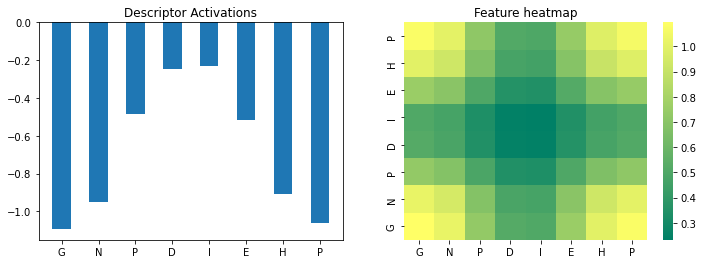

Seq: PFPIIV, Label: 1, Cls prob: [-1.3590346574783325, 1.4671423435211182]


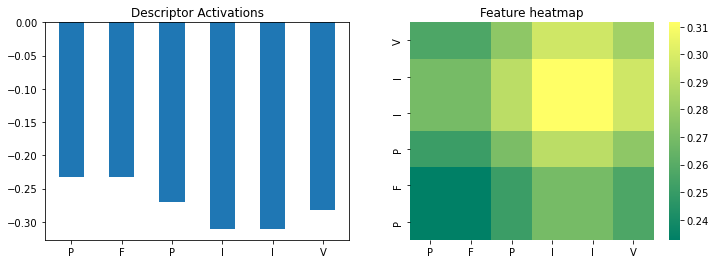

Seq: EMPFPK, Label: 0, Cls prob: [-0.6600723266601562, 0.7372912168502808]


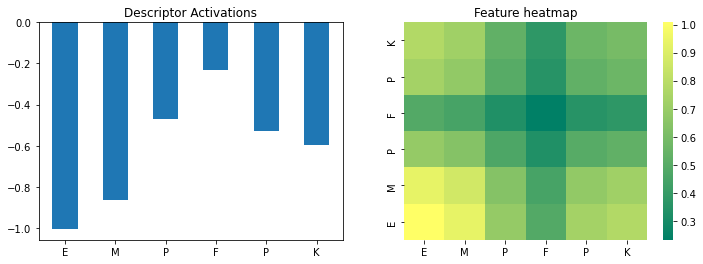

Seq: RGPPGGF, Label: 1, Cls prob: [-1.3590346574783325, 1.4671423435211182]


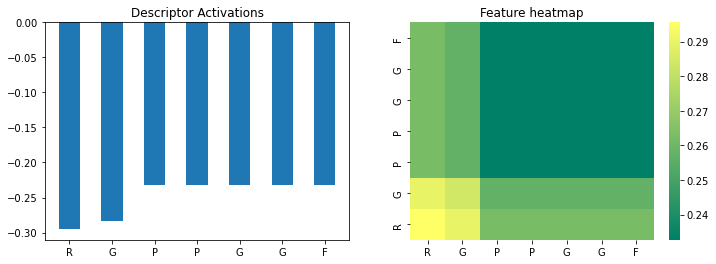

In [61]:
#i = np.random.randint(640)
#print(i)
for i in np.random.choice(640, 15):
    print(f'Seq: {descs[i]}, Label: {labels[i]}, Cls prob: {pred_vals[i].tolist()}')
    fig, ax = plt.subplots(1,2,figsize=(12, 4))
    #print(f'Activation: {conv_feats[i]}')
    ax[0].bar(x=np.arange(len(descs[i])), height = conv_feats[i], width=-.5)
    #plt.plot(conv_feats[i])
    ax[0].set_xticks(np.arange(len(descs[i])), [c for c in descs[i]])
    ax[0].set_title('Descriptor Activations')
    sns.heatmap(np.sqrt(np.rot90(np.abs(np.matmul(np.matrix(conv_feats[i]).T, np.matrix(conv_feats[i]))))), cmap = 'summer', ax = ax[1]) #annot=True, 

    ax[1].set_xticks(np.arange(len(descs[i]))+0.5, labels=[c for c in descs[i]])
    ax[1].set_yticks(np.arange(len(descs[i]))+0.5, labels=descs[i][::-1])
    ax[1].set_title('Feature heatmap')
    plt.show()

Seq: QQPVLGPVRGPFPI, Label: 1, Cls prob: [-0.9801537990570068, 1.071517825126648]


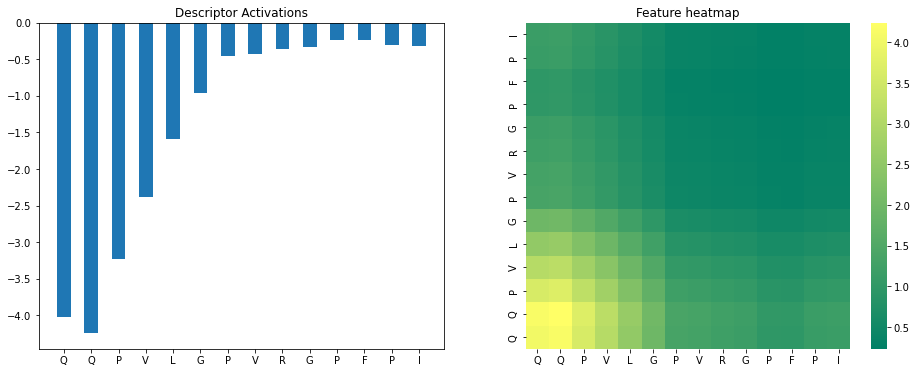

Seq: KFHSGIQSEPKAIP, Label: 0, Cls prob: [1.869553565979004, -1.9041250944137573]


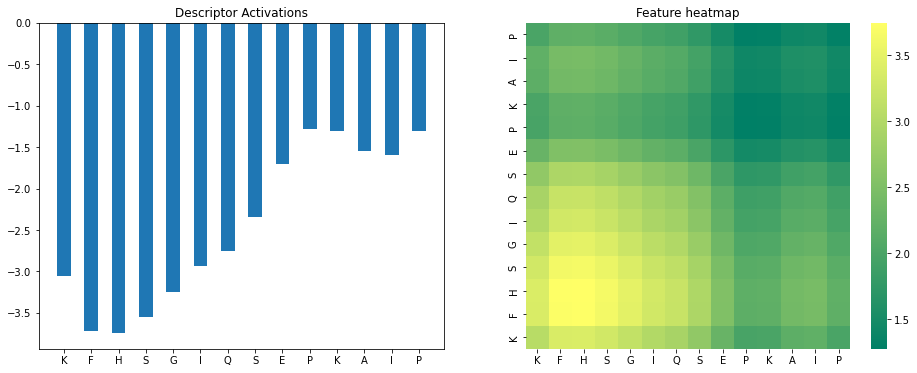

Seq: PVLGPVRGPFPIIV, Label: 1, Cls prob: [-0.8658463954925537, 0.9521589279174805]


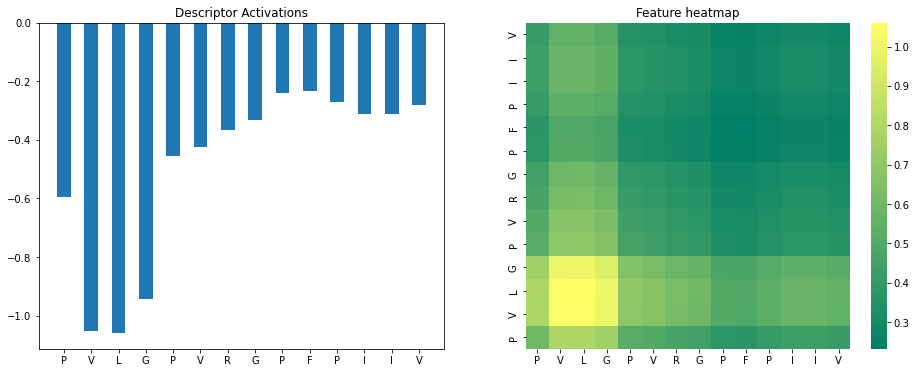

Seq: KIYPSFQPQPLIYP, Label: 0, Cls prob: [1.4887137413024902, -1.5064550638198853]


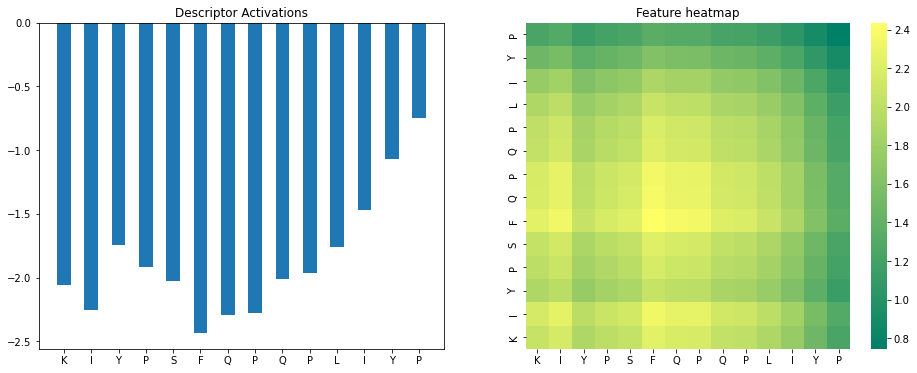

Seq: YQEPVLGPVRGPFPI, Label: 1, Cls prob: [-0.612471342086792, 0.6875866651535034]


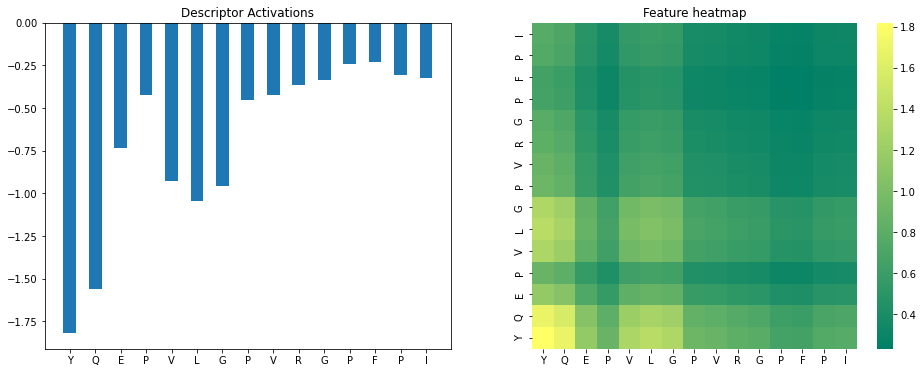

Seq: ENGLPVHLDQSIFRR, Label: 0, Cls prob: [0.4679300785064697, -0.44056037068367004]


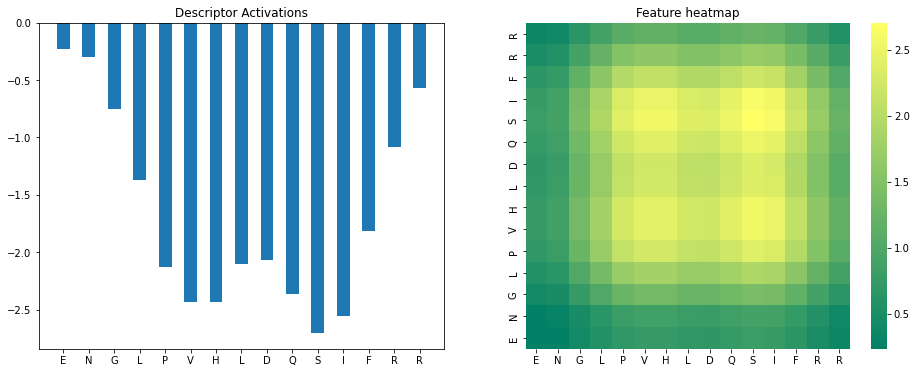

Seq: QPVLGPVRGPFPIIV, Label: 1, Cls prob: [-1.0507792234420776, 1.1452645063400269]


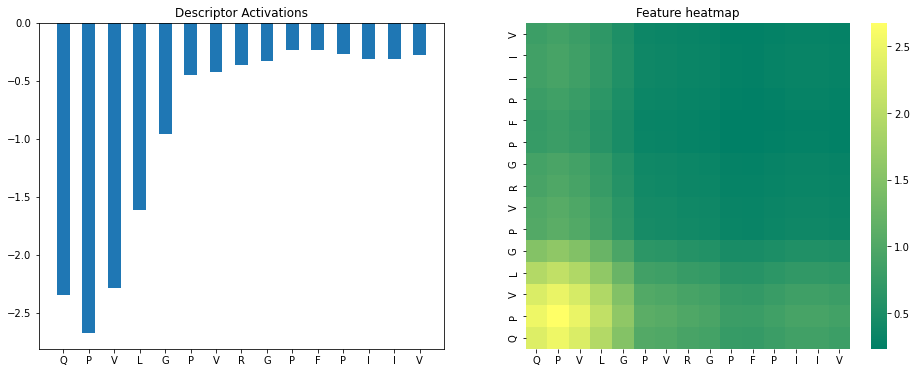

Seq: DKIYPSFQPQPLIYP, Label: 0, Cls prob: [1.321401596069336, -1.3317488431930542]


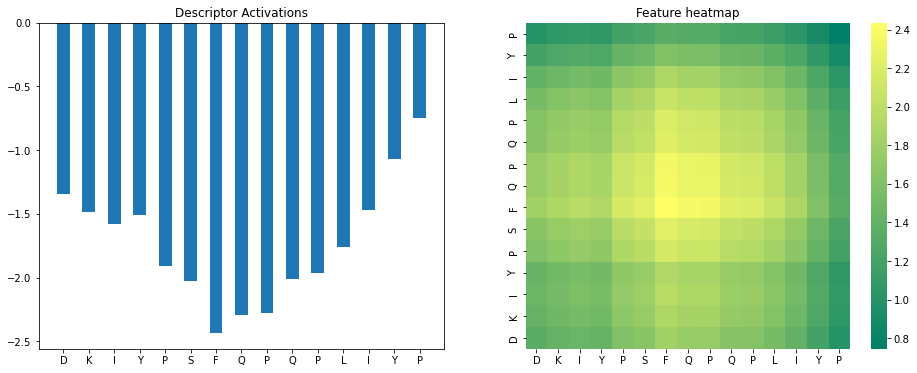

Seq: YQQPVLGPVRGPFPI, Label: 1, Cls prob: [-0.9438799023628235, 1.0336412191390991]


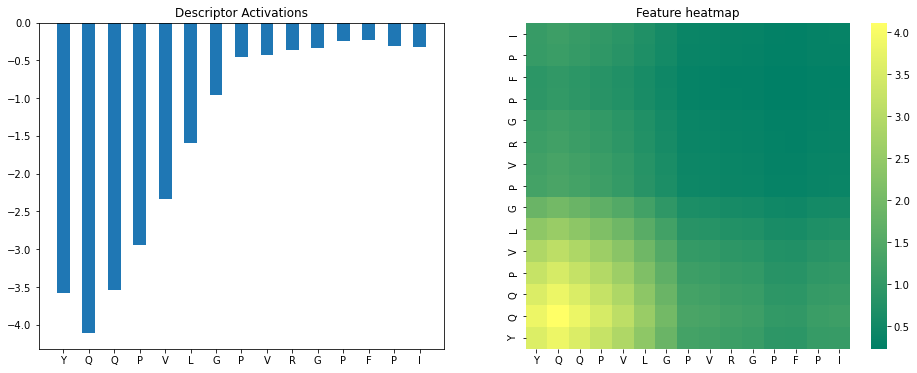

Seq: YQQPVLGPVRGPFPII, Label: 1, Cls prob: [-0.839629590511322, 0.9247837066650391]


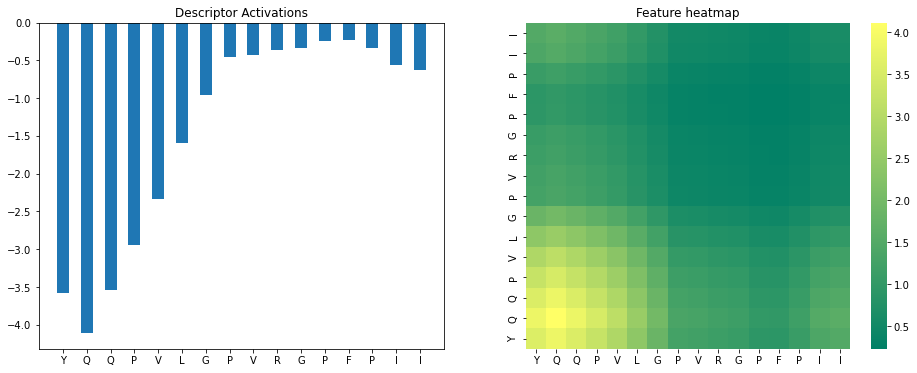

Seq: ENGLPVHLDQSIFRRP, Label: 0, Cls prob: [0.21040049195289612, -0.17164990305900574]


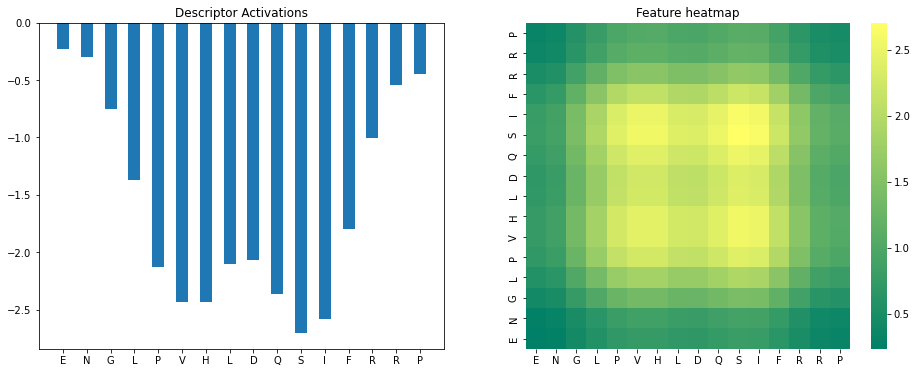

Seq: APKHKEMPFPKYPVEPF, Label: 1, Cls prob: [-0.6125620603561401, 0.6877812743186951]


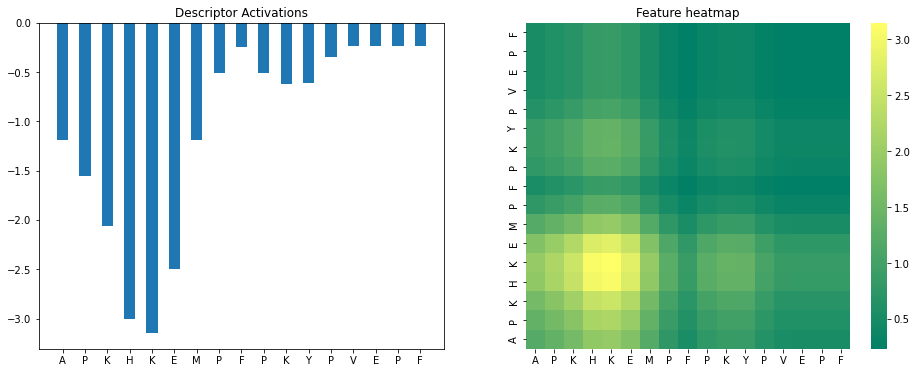

Seq: YQQPVLGPVRGPFPIIV, Label: 1, Cls prob: [-0.9927217364311218, 1.0846413373947144]


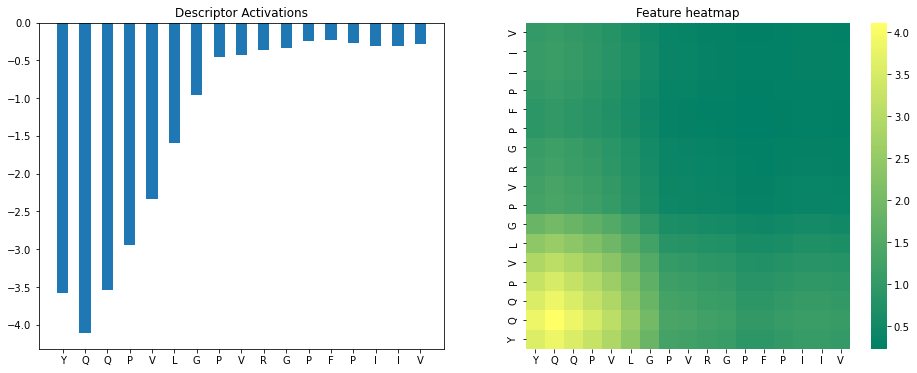

Seq: YQEPVLGPVRGPFPIIV, Label: 1, Cls prob: [-0.700302243232727, 0.7792990207672119]


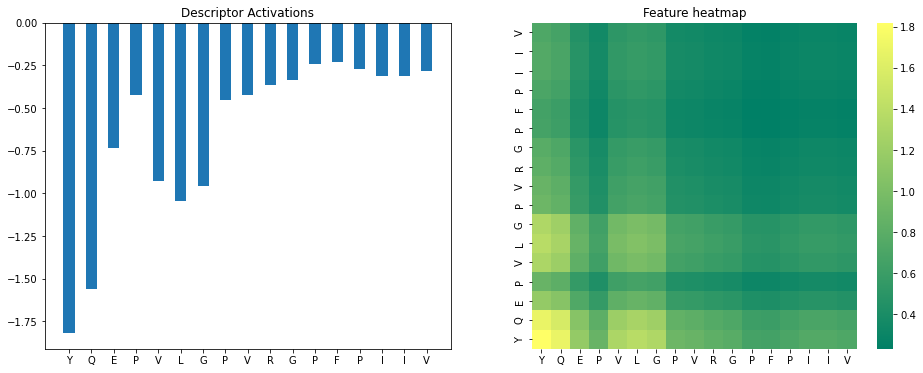

Seq: MAPKHKEMPFPKYPVEPF, Label: 1, Cls prob: [-0.426114022731781, 0.49310171604156494]


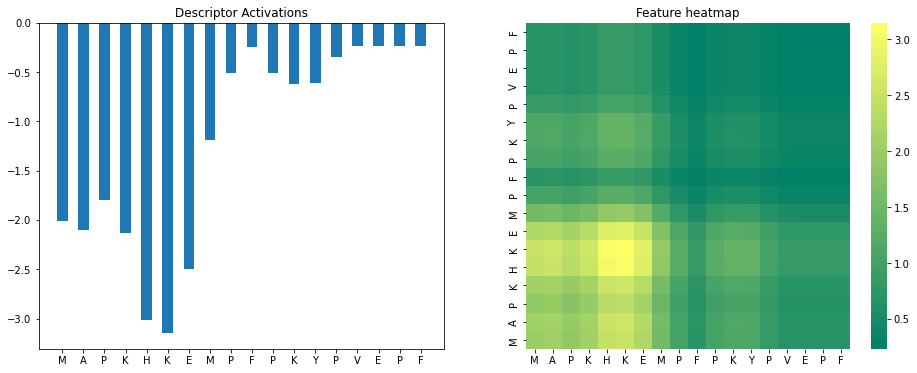

Seq: LVYPFPGPIPNSLPQNIPP, Label: 0, Cls prob: [-0.5015350580215454, 0.5717478394508362]


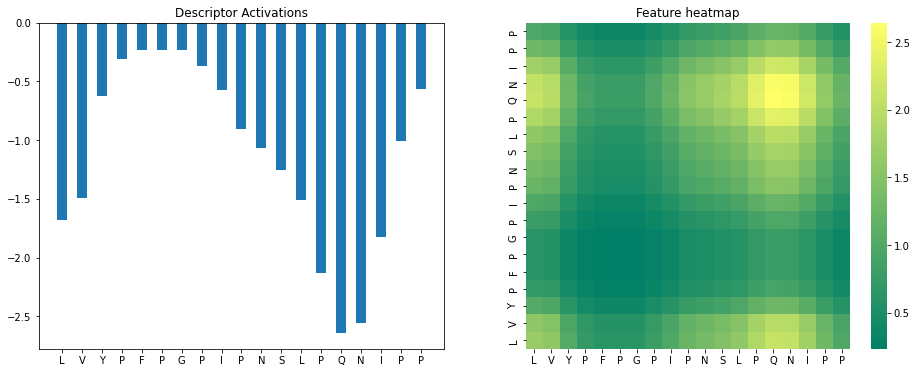

Seq: QDKIHPFAQTQSLVYPFPGP, Label: 1, Cls prob: [0.17301532626152039, -0.13261249661445618]


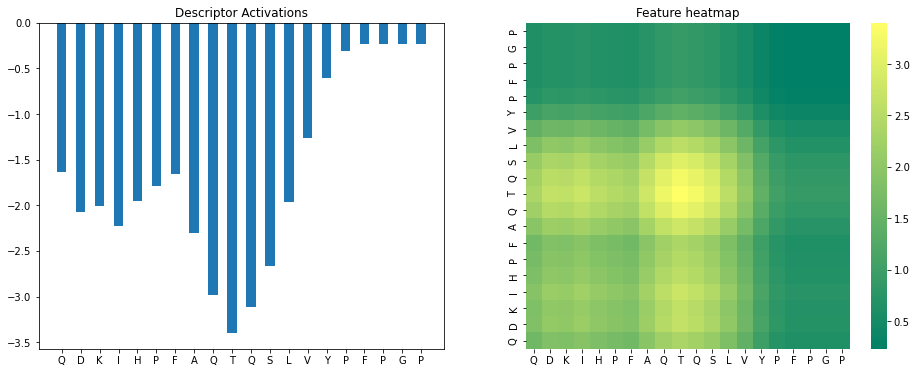

Seq: QNDKIHPFAQTQSLVYPFGPIP, Label: 1, Cls prob: [-0.07501303404569626, 0.12637679278850555]


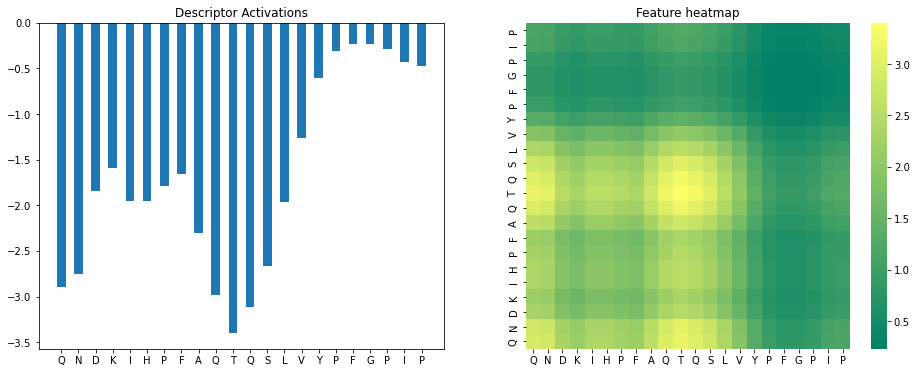

Seq: AQTQSLVYPFPGPIPNSLPQNIPPLTQ, Label: 1, Cls prob: [-0.17704832553863525, 0.23292122781276703]


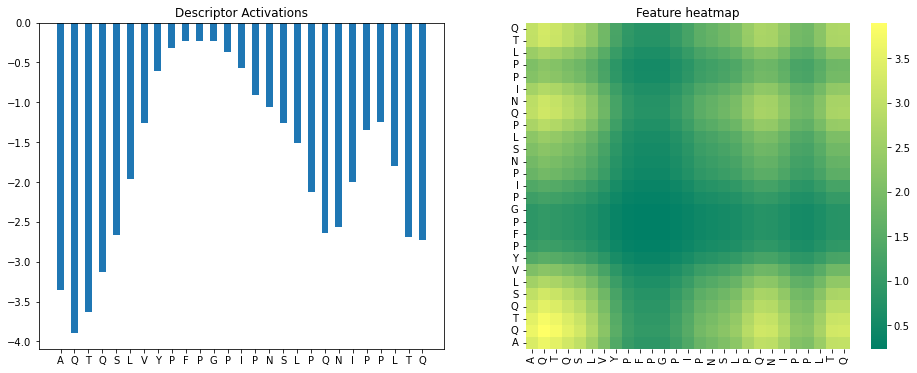

Seq: QNDKIHPFAQTQSLVYPFGPIPNSLPQNIPPLTQTPVVV, Label: 1, Cls prob: [-0.08534424006938934, 0.13716453313827515]


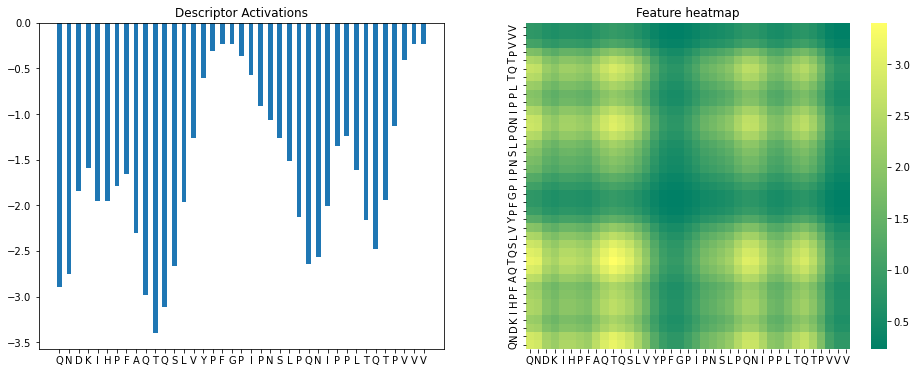

In [62]:
#i = np.random.randint(640)
#print(i)
for i in np.argsort([len(i) for i in descs])[-20:]:
    print(f'Seq: {descs[i]}, Label: {labels[i]}, Cls prob: {pred_vals[i].tolist()}')
    fig, ax = plt.subplots(1,2,figsize=(16, 6))
    #print(f'Activation: {conv_feats[i]}')
    ax[0].bar(x=np.arange(len(descs[i])), height = conv_feats[i], width=-.5)
    #plt.plot(conv_feats[i])
    ax[0].set_xticks(np.arange(len(descs[i])), [c for c in descs[i]])
    ax[0].set_title('Descriptor Activations')
    sns.heatmap(np.sqrt(np.rot90(np.abs(np.matmul(np.matrix(conv_feats[i]).T, np.matrix(conv_feats[i]))))), cmap = 'summer', ax = ax[1]) #annot=True, 

    ax[1].set_xticks(np.arange(len(descs[i]))+0.5, labels=[c for c in descs[i]])
    ax[1].set_yticks(np.arange(len(descs[i]))+0.5, labels=descs[i][::-1])
    ax[1].set_title('Feature heatmap')
    plt.show()